# Global PCA model training

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import ast
from nltk.corpus import stopwords
from gensim.utils import tokenize
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib
from gensim.models.doc2vec import Doc2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [2]:
df = pd.read_csv('../data/lyrics.csv')

In [3]:
df.head()

,lyrics,genre,outlier,id
0,"['Go, go, go, go', 'Go, go, go shawty', ""It's ...",rap,False,0
1,"['New York City!', 'You are now rapping...with...",rap,False,1
2,"[""I don't know what you heard about me"", ""But ...",rap,False,2
3,"['Man we gotta go get something to eat man', ""...",rap,False,3
4,"['Yeah...', 'Uh huh', 'So seductive', ""I'll ta...",rap,False,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37015 entries, 0 to 37014
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lyrics   37015 non-null  object
 1   genre    37015 non-null  object
 2   outlier  37015 non-null  bool  
 3   id       37015 non-null  int64 
dtypes: bool(1), int64(1), object(2)
memory usage: 903.8+ KB


In [5]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))

In [6]:
idxs_eval = pd.read_csv('../data/evaluation/lyrics_eval.csv')['id']
idxs_test = pd.read_csv('../data/classification/lyrics_test.csv')['id']

In [7]:
indexes2delete = list(idxs_eval) + list(idxs_test)

In [8]:
df.drop(indexes2delete, inplace=True)
df.reset_index(inplace=True)

In [9]:
lyrics = list(df['lyrics'])
genres = list(df['genre'])

verses = [verse for lyr in lyrics for verse in lyr]
genres_by_verse = [genre for lyr, genre in zip(lyrics, genres) for verse in lyr]

lyrics_indexes = [i for i, lyr in enumerate(lyrics) for verse in lyr]
verse_indexes = [i for lyr in lyrics for i, verse in enumerate(lyr)]

verse_df = pd.DataFrame({'verse': verses, 'genre': genres_by_verse, 
                         'lyrics_id': lyrics_indexes, 'verse_id': verse_indexes})

verse_df = verse_df.groupby('genre').sample(frac=0.05, random_state=0).reset_index()
#verse_df = verse_df.groupby('genre').sample(n=25, random_state=0).reset_index()

In [10]:
verse_df.head()

,index,verse,genre,lyrics_id,verse_id
0,787527,Until the moment I take my final breath~~,rap,14546,21
1,1156126,"You hot, thirst?",rap,21419,16
2,580544,"I'mma take my time, I'mma master it",rap,11329,17
3,1148006,Forever like a juvenile,rap,21295,63
4,649668,"I can't even blame 'em though, the drug game l...",rap,12425,67


## Features

In [ ]:
# Get features from a specific verse based on its index in the lyrics
get_features_verse = lambda x, index: [v[index] for v in x.values()]

# Compute lyrics statistics of lyrics with index_id i, get verse statistics from verse_id j
features_by_verse = [get_features_verse(lyrics_statistics(df['lyrics'][row['lyrics_id']]), row['verse_id']) 
                    for index, row in tqdm(verse_df.iterrows())]

features_by_verse = np.array(features_by_verse)

In [12]:
scaler = StandardScaler()
scl_features_by_verse = scaler.fit_transform(np.array(features_by_verse))

In [13]:
pca = PCA(n_components=1, random_state=0)
pca.fit(scl_features_by_verse)

PCA(n_components=1, random_state=0)

In [14]:
joblib.dump(pca, '../models/features_pca.pkl')
joblib.dump(scaler, '../models/features_scaler.pkl')

['../models/features_scaler.pkl']

In [15]:
scaler = joblib.load('../models/features_scaler.pkl')
pca = joblib.load('../models/features_pca.pkl')

['Here along we wander and we roam', 'We cut our teeth in city streets and gutters we call home', 'Await the day the clouds will part', 'Deliver words we know by heart', 'Raise your fucking voice', 'Or be a face in the crowd', "Isn't that what it's all about?", 'So tempt me not with the life you have bought', 'Our keep is earned in the change that we sought', 'Explain away the tangled truth', 'Accuse away but without proof', 'Raise your fucking voice', 'Or be a face in the crowd', "Isn't that what it's all about?", 'Boots on the ground, aim tried and true', 'Bells toll the sound; impending doom', 'In our respite our numbers grew', "Now it's time to", 'Raise your fucking voice', 'Or be a face in the crowd', "Isn't that what it's all about?", 'Is that what this is about?', 'byLéoPS']


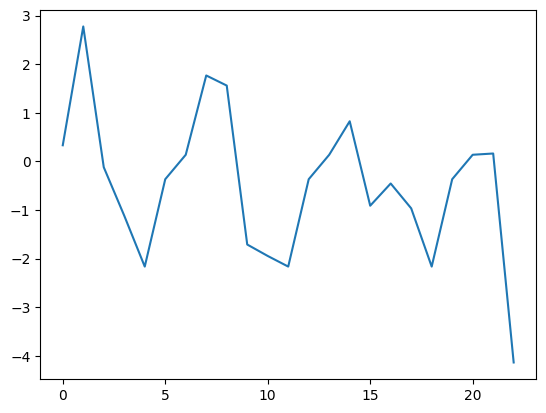

In [16]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = pd.DataFrame(lyrics_statistics(random_lyrics)).values
eg_scl_multi_ts = scaler.transform(eg_multi_ts)
eg_uni_ts = list(
    map(lambda unique_element: unique_element[0], pca.transform(eg_scl_multi_ts)))
plt.plot(eg_uni_ts)

## Sentence BERT

In [17]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [18]:
embeddings = [model.encode([verse]) for verse in tqdm(verse_df['verse'])]

embeddings = np.concatenate(embeddings, axis=0)

100%|██████████████████████████████████████████████████████████████| 75491/75491 [23:26<00:00, 53.68it/s]


In [19]:
pca = PCA(n_components=1, random_state=0)
pca.fit(embeddings)

PCA(n_components=1, random_state=0)

In [20]:
joblib.dump(pca, '../models/sbert_pca.pkl')

['../models/sbert_pca.pkl']

In [21]:
pca = joblib.load('../models/sbert_pca.pkl')

["Save me from tomorrow's sins", 'Cause I been down this road', 'And where it goes it never ends', 'Wake me... my mind has been enslaved', 'Or am I so far gone', "I'll never be myself again", 'Hate, shame', "Who's to blame?", "Where's the world I used to know", 'A change has come from every side', 'Only to divide', 'A soul sickness in the bones', 'What happened to, what happened to the world', 'I used to know', 'Help me... someone take my hand', 'So heavy no fight left', 'Losing grip in the quicksand', 'With every move I make', 'Sink deeper, suffocate', 'A nightmare future that you never will escape', 'Hate, shame', "Who's to blame?", "Where's the world I used to know", 'A change has come from every side', 'Only to divide', 'A soul sickness in the bones', 'What happened to, what happened to the world', 'I used to know', 'The world I used to know', 'What have we done?', 'What have we done?', 'What have we done?', 'With the world I used to know', 'Change has come from every side', 'Only 

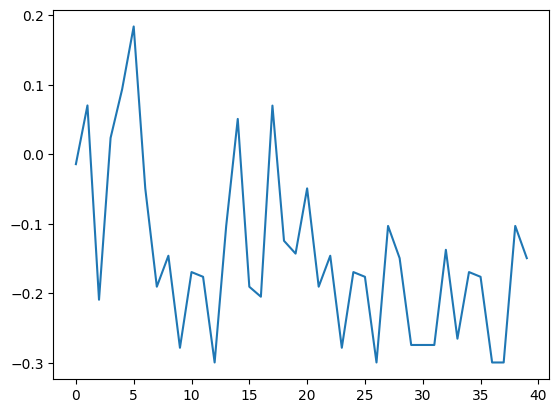

In [22]:
# Generate a multivariate time series for text as a sequence of sentence embedding (SBERT)
generate_multi_ts = lambda lyrics, model: np.array([model.encode(verse) for verse in lyrics])

random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = generate_multi_ts(random_lyrics, model)
eg_uni_ts = list(
    map(lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Doc2Vec

In [23]:
model = Doc2Vec.load("../models/doc2vec.model")

In [24]:
def tokenize_verse(verse, remove_stop_words=True):
    tokens = list(tokenize(verse, lowercase=True))
    if remove_stop_words:
        stop_words = stopwords.words('english')
        tokens = [token for token in tokens if token not in stop_words]    
    return tokens

In [25]:
tokenized_verses = [tokenize_verse(verse) for verse in verse_df['verse']]

In [26]:
embeddings = np.array([model.infer_vector(verse) for verse in tqdm(tokenized_verses) if verse])

100%|████████████████████████████████████████████████████████████| 75491/75491 [00:52<00:00, 1437.27it/s]


In [27]:
scaler = StandardScaler()
scl_embeddings = scaler.fit_transform(np.array(embeddings))

In [28]:
pca = PCA(n_components=1, random_state=0)
pca.fit(scl_embeddings)

PCA(n_components=1, random_state=0)

In [29]:
joblib.dump(pca, '../models/d2v_pca.pkl')
joblib.dump(scaler, '../models/d2v_scaler.pkl')

['../models/d2v_scaler.pkl']

In [30]:
scaler = joblib.load('../models/d2v_scaler.pkl')
pca = joblib.load('../models/d2v_pca.pkl')

["Stackin' my paper up, no, I don't make enough", "All of these niggas, I smoke when I'm wakin' up", "No, I ain't fake enough, money I'm rakin' up", "Tell 'em I ain't takin up, got ya girl bakin' up", "Yo bitch, she makin' up, my crib, I'm takin' up", "Pillow, her face in there, whole lot of space in 'em", "My car, I'm racin' it, crash and replacin' it", "Don't put the basics in, smokin' the face in it", 'Came from the bottom, I know where the basement is', "Real G's movin' silent, my niggas are dangerous", "Smoke every day and I don't miss a plane", "Stack everythin' at the club, make it rain", "Got a new broad and she gettin' me paid", 'Fuck niggas hate, guess that comes with the game', 'Got a new car and a bust down', "I was down bad, but I'm up now", "When I buff, now loud, when I come 'round", 'And we just met, she in love now', "I'm a straight player, I don't cuff now", 'I get to the bag, got this run round', "I'm on KK, I've been one pound", "When I call the play, it's a touchdo

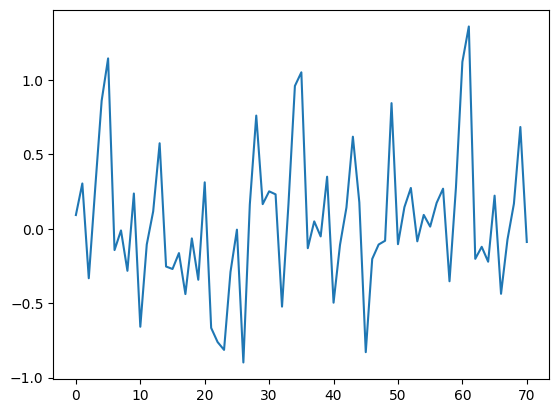

In [31]:
# Generate a multivariate time series for text as a sequence of sentence embedding (Doc2Vec)
generate_multi_ts = lambda lyrics, model: np.array([model.infer_vector(verse) for verse in lyrics])

random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

tokenized_lyrics = list(map(lambda x: tokenize_verse(x), random_lyrics))
eg_multi_ts = generate_multi_ts(tokenized_lyrics, model)
eg_uni_ts = list(
    map(lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Emotion

In [32]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [33]:
def get_logits(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    return logits

In [34]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [35]:
logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in tqdm(list(verse_df['verse']))]

100%|████████████████████████████████████████████████████████████| 75491/75491 [1:14:43<00:00, 16.84it/s]


In [36]:
# Convert tensors to numpy array
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [37]:
tsne_model = TSNE(n_components=2, random_state=0, init='pca')

In [38]:
tsne_logits = pd.DataFrame(tsne_model.fit_transform(logits), columns=['x','y'])
tsne_logits['label'] = labels

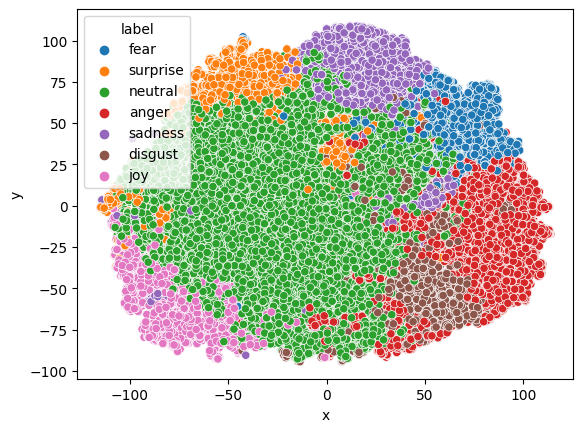

In [39]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=tsne_logits, x='x', y='y', hue='label')
plt.show()

In [40]:
scaler = StandardScaler()
scl_logits = scaler.fit_transform(logits)

In [41]:
pca = PCA(n_components=1, random_state=0)
pca.fit(scl_logits)

PCA(n_components=1, random_state=0)

In [42]:
joblib.dump(pca, '../models/emo_pca.pkl')
joblib.dump(scaler, '../models/emo_scaler.pkl')

['../models/emo_scaler.pkl']

In [43]:
scaler = joblib.load('../models/emo_scaler.pkl')
pca = joblib.load('../models/emo_pca.pkl')

['Yeah', 'gangsta', "Tell me all my children fore i come throught is the hood in the buildin'", 'You wont belive what im dealing this west coas shit, oh what a feelin ', "Niggaz think im drug dealin cus i roled out with no muthafuckin' sealing ", 'Is he worth a hundren million no need to ask Ice Cube how im livin ', 'I still got the recipe, South Central LA is the pedigree', 'Dont try to tell me wuh it better be, i have your ass up in physical therapy', 'I outlaw like a Cherokee, the rap industry tried to bury me', 'But if i die on a mike of a leraby im so heavy u bitches couldnt carry me', "Get money, spend money, no money, lookin' like a dummy ", 'Your money aint my fucking money got a pocket full of money ', "Get money, spend money, no money, lookin' like a dummy ", 'Your money aint my fucking money got a pocket full of money ', 'I dont accept no disrespect only thing i expect is self check', 'Just grin and bare it, got an ass whooping that your ass dont wanna inherit', 'Most rapper

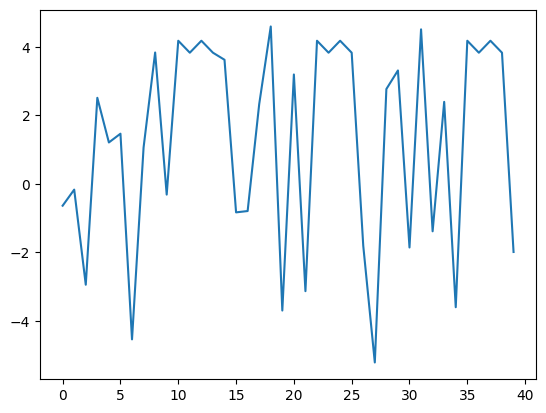

In [44]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in random_lyrics]

# Convert tensors to numpy array
eg_multi_ts = np.array([lt[0].numpy() for lt in logits_tensor])
eg_uni_ts = list(
    map(lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)